## Loading data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2024-11-02 02:20:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.12.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   202MB/s    in 0.3s    

2024-11-02 02:20:04 (202 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Reading the Data into arrays

In [3]:
from PIL import Image
import numpy as np


cats_dir = os.path.join(train_dir + "/cats")
dogs_dir = os.path.join(train_dir + "/dogs")

x_train = []
y_train = []

i = 0
while i < min(len(os.listdir(cats_dir)),len(os.listdir(dogs_dir))):
  if i % 2 == 0:
    im = Image.open(os.path.join(cats_dir, os.listdir(cats_dir)[i])).convert("RGB")
    im_resized = im.resize((150, 150))
    x_train.append(np.array(im_resized))
    y_train.append(1)
  else:
    im = Image.open(os.path.join(dogs_dir, os.listdir(dogs_dir)[i])).convert("RGB")
    im_resized = im.resize((150, 150))
    x_train.append(np.array(im_resized))
    y_train.append(0)
  i += 1

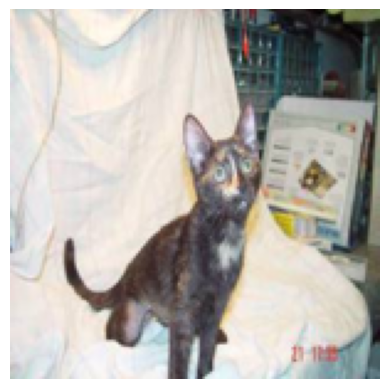

In [4]:
#test image
import matplotlib.pyplot as plt

im = Image.fromarray(x_train[0])

# Display the image
plt.imshow(im)
plt.axis('off')  # Optional: turn off axis numbers
plt.show()

## Beginning to define the model (this is where you come in, I loaded the pretrained model for you)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Initialize the Sequential model
resnet_model = Sequential()

# Load ResNet50 with input shape specified explicitly in Sequential
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
)

# Freeze the layers in ResNet50
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained ResNet model with input shape specified in Sequential
resnet_model.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))  # Define input shape here
resnet_model.add(pretrained_model)

# Add custom layers
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))  # Binary output

# Print model summary
resnet_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
#force use of CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

epochs = 10
history = resnet_model.fit(
    np.array(x_train),
    np.array(y_train),
    epochs=epochs,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9903 - loss: 0.0279 - val_accuracy: 0.9400 - val_loss: 0.1777
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9982 - loss: 0.0082 - val_accuracy: 0.9450 - val_loss: 0.1629
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9994 - loss: 0.0055 - val_accuracy: 0.9450 - val_loss: 0.1837
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9350 - val_loss: 0.1833
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9450 - val_loss: 0.1851
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9450 - val_loss: 0.1881
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9400 - val_loss: 0.1893
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 1.0000 - loss: 8.1105e-04 - val_accuracy: 0.9450 

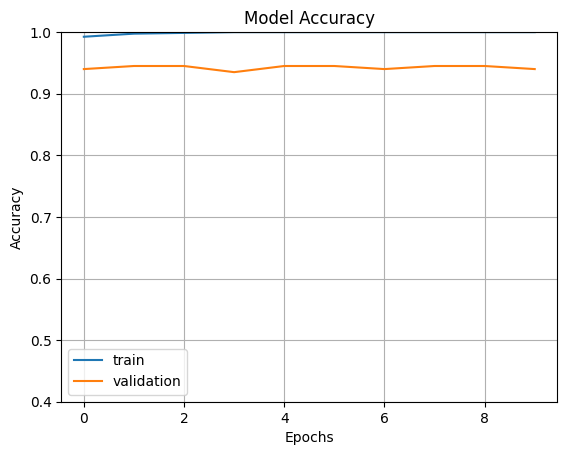

In [13]:
#Evalutating Model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


<ipython-input-16-fba9a83db671>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = int(prediction[0] > 0.5)  # Assuming a binary classification


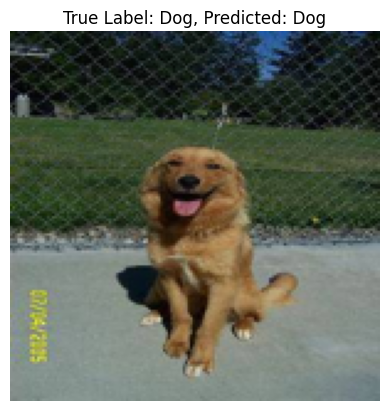

In [16]:
sample_image = x_train[7]
sample_label = y_train[7]

# Preprocess image for the model (if necessary, e.g., scaling or normalization)
sample_image_processed = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Get the model's prediction
prediction = resnet_model.predict(sample_image_processed)
predicted_label = int(prediction[0] > 0.5)  # Assuming a binary classification

# Display the image
plt.imshow(sample_image)
plt.axis('off')
plt.title(f"True Label: {'Cat' if sample_label == 1 else 'Dog'}, "
          f"Predicted: {'Cat' if predicted_label == 1 else 'Dog'}")
plt.show()